# Project on Support Vector Machines
## Optimization Techniques
### Instructor: E. Markakis
### Team: Natasa Farmaki(DS3517018),  Stratos Gounidellis(DS3517005)

## Support Vector Machines Overview

Support Vector Machines is a supervised machine learning algorithm which can be used for either classification or regression tasks. Indeed, it is considered to be one of the best supervised learning algorithms.  Given a set of training examples, each of them assigned to a class (either to -1 or to 1 in the simple case) we aim to predict the class of the test examples in a classification task. Using the SVM machine learning algorithm we aim to compute that hyperplane that separates the two classes better.

Support vectors are simply the closest vectors, from each class, to the classifier. Moreover, apart from linear classification Support Vector Machines can be used for non-linear classification. In order to achieve that we use the kernel trick, i.e. we implicitly map the input into high-dimensional feature spaces. Examples of kernel functions are:
1. Radial basis functions (for appropriate values of σ)
2. Polynomial (for appropriate values of q)
3. Hyperbolic tangent (for appropriate values of β and γ)

Sources: [https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/, http://cs229.stanford.edu/notes/cs229-notes3.pdf]


## Sequential Minimal Optimization Overview 

Sequential Minimal Optimization is an algorithm invented by John Platt in 1998 at Microsoft Research. It was accepted with a lot of excitement as till then training of SVMs required the use of expensive and relatively slow quadratic programming software. 

More specifically, training a support vector machine requires solving a very large quadratic programming optimization problem. However, according to the SMO approach that very large problem is broken into smaller subproblems that are tractable and can be solved analytically. That approach is memory efficient as there is no need to store the constraint matrix. Therefore, SMO is capable of handling large training sets while it is faster for linear SVMs and sparse data sets. Indeed, according to Platt's paper SMO can be up to 1000 times faster than the chunking algorithm on realword sparse data sets.

When implementing the algorithm several decisions should be taken, such as:
- How to pick the pair of variables that will be examined in each iteration,
- How to pick an initial solution,
- How to set the termination criterion.

All those decisions are clarified through comments in the source code as well as in the report accompanying the project.

Source: [https://www.microsoft.com/en-us/research/publication/sequential-minimal-optimization-a-fast-algorithm-for-training-support-vector-machines/]

## Implementation

In [23]:
import numpy as np
import math
import pickle
import time
from scipy.linalg import norm
import pandas as pd
from sklearn.cross_validation import train_test_split
import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from copy import copy, deepcopy
import pandas as pd
from sympy import *
import mpmath
from scipy.spatial.distance import cdist
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.font_manager import FontProperties
import warnings

In [3]:
# read the data to classify with the SVM classifier
def read_data(file, len_lines):

    # output vector
    target = []
    # training point matrix
    point = []
    temp = []
    
    # open the file and store the lines
    with open(file, 'r', encoding='utf-8') as infile:
        lines = infile.read().split('\n')

    if len_lines is None or len_lines > len(lines):
        len_lines = len(lines)

    for line in lines[:len_lines]:

        if (len(line)):
            # split each line on the whitespace char
            observation = line.strip().split(' ')
            features = observation[1:]
            for feature in features:
                # store the features of each observation
                temp.append(float(feature.strip().split(':')[1]))
            if (len(temp)) != 4955:
                temp = []
                continue
            # append the features of the current observation
            point.append(temp)
            # append the class of the current observation
            target.append(float(observation[0]))
            temp = []

    target = np.asarray(target)
    point = np.asmatrix(point)
    # return the two matrices
    return target, point


##  Functions

### SMO Functions

In [4]:
# compute and store the rbf(gaussian) kernel between X and Y
def gaussianMatrix(X, Y, sigma):
    pairwise_sq_dists = cdist(X, Y, 'sqeuclidean')
    kernel_matrix = scipy.exp(-pairwise_sq_dists * 2 / sigma * 2)
    return kernel_matrix


# compute and store the linear kernel between X and Y
def linearMatrix(X, Y):
    linear_matrix = np.dot(X, Y.T)
    return linear_matrix


# return the linear(gaussian) kernel stored in the above matrices
def kernel(i, j, kernel_matrix, k="linear", sigma=1):
    if k == "linear":
        return kernel_matrix[i, j]
    elif k == "gaussian":
        return kernel_matrix[i, j]

    
# choose the second alpha to optimize according to the second choice heuristic and call
# takeStep method.
def examineExample(i2, point, target, C, kernel_matrix, k="linear", sigma=1, tol=0.001):
    # declare global variables
    global alphas
    global w
    global beta
    global E

    # get label, lagrange multiplier and error for element in position i2
    y2 = target[i2]
    alpha2 = alphas[i2]
    E2 = E[i2]
    r2 = E2 * y2

    # find positions of non-bound examples
    non_bound = (np.where(alphas != 0) and np.where(alphas != C))
    # if error is within tolerance
    if ((r2 < -tol and alpha2 < C) or (r2 > tol and alpha2 > 0)):
        # if number of non-zero and non-C alpha is greater than 1
        # use second choice heuristic
        if(len(non_bound[0]) > 1):
            if E2 > 0:
                # choose minimum error if e2 is positive
                i1 = np.argmin(E)
            elif(E2 < 0):
                # choose maximum error if e2 is negative
                i1 = np.argmax(E)
            if takeStep(i1, i2, target, point, C, kernel_matrix, k, sigma):
                return 1

        # loop over all non-zero and non-C alpha starting at a random point
        random_index = non_bound[0]
        random_index = random_index[np.random.permutation(len(random_index))]
        for i in random_index:
            # choose identity of current alpha
            if (alphas[i] == alphas[i2]):
                i1 = i
                if takeStep(i1, i2, target, point,  C, kernel_matrix, k, sigma):
                    return 1
        # loop over all possible indices starting at a random point
        temp = np.arange(0, len(alphas))
        temp = temp[np.random.permutation(len(temp))]
        for i in temp:
            # loop variable
            i1 = i
            if takeStep(i1, i2, target, point, C, kernel_matrix, k, sigma):
                return 1
    return 0

                
# update threshold, weight vector(if linear svm), error cache, alphas
def takeStep(i1, i2, target, point, C, kernel_matrix, k="linear", sigma=1, eps=0.001):
    # declare global variables
    global alphas
    global w
    global beta
    global E

    # if alphas are the same return 0
    if i1 == i2:
        return 0
    # get label, lagrange multiplier and error for elements in position i1, i2
    alpha1, alpha2 = alphas[i1], alphas[i2]
    y1, y2 = target[i1], target[i2]
    E1, E2 = E[i1], E[i2]

    s = y1 * y2

    # compute L, H depending on the values of the labes y1,y2
    if y1 != y2:
        L = max(0, alpha2 - alpha1)
        H = min(C, C + alpha2 - alpha1)
    else:
        L = max(0, alpha2 + alpha1 - C)
        H = min(C, alpha2 + alpha1)

    if (L == H):
        return 0

    # calculate the second derivative of the objective function
    # along the diagonal line, i.e. eta
    k11 = kernel(i1, i1, kernel_matrix, k, sigma)
    k12 = kernel(i1, i2, kernel_matrix, k, sigma)
    k22 = kernel(i2, i2, kernel_matrix, k, sigma)
    eta = k11 + k22 - 2 * k12
    # if the second derivative is positive, update alpha2
    # using the following formula
    if (eta > 0):
        a2 = alpha2 + y2*(E1 - E2) / eta
        # clip a2 according to bounds
        if (a2 < L):
            a2 = L
        elif (a2 > H):
            a2 = H
    else:
        # evaluate the objective function at each end of the line
        # segment
        f1 = y1 * (E1 + beta) - alpha1 * k11 - s * alpha2 * k12
        f2 = y2 * (E2 + beta) - s * alpha1 * k12 - alpha2 * k22
        L1 = alpha1 + s * (alpha2 - L)
        H1 = alpha1 + s * (alpha2 - H)
        # objective function at a2 = L
        obj_L = L1 * f1 + L * f2 + (1/2) * ((L1)**2) * k11 + (1/2) * (L**2) * k22 + s * L * L1 * k12
        # objective function at a2 = H
        obj_H = H1 * f1 + H * f2 + (1/2) * ((H1)**2) * k11 + (1/2) * (H**2) * k22 + s * H * H1 * k12
        if (obj_L < (obj_H - eps)):
            a2 = L
        elif (obj_L > (obj_H + eps)):
            a2 = H
        else:
            a2 = alpha2

    # if a2 very close to zero or C set a to 0 or C respectively
    if a2 < (10**(-8)):
        a2 = 0.0
    elif(a2 > C - (10**-8)):
        a2 = C
    # if difference between a_new and a_old is negligible return 0
    if(abs(a2 - alpha2) < (eps*(a2 + alpha2 + eps))):
        return 0

    # compute new alpha1
    a1 = alpha1 + s * (alpha2 - a2)

    # compute threshold b
    b1 = E1 + y1 * (a1 - alpha1) * k11 + y2 * (a2 - alpha2) * k12 + beta
    b2 = E2 + y1 * (a1 - alpha1) * k12 + y2 * (a2 - alpha2) * k22 + beta

    # According to Platt's SMO paper 2.3 threshold b is b1 if a1 is not in
    #  bounds, b2 is when a2 is not at bounds and (b1+b2)/2
    # when both a1, a2 are at bounds.
    beta_new = 0
    if 0 < a1 < C:
        beta_new = b1
    elif 0 < a2 < C:
        beta_new = b2
    else:
        beta_new = (b1 + b2) / 2

    t1 = y1 * (a1 - alpha1)
    t2 = y2 * (a2 - alpha2)

    # update weight vector to reflect change in alpha1 and alpha2 if SVM is linear
    if (k == "linear"):
        w = w + t1 * point[i1, :] + t2 * point[i2, :]

    delta_b = beta - beta_new

    # update error cache using new lagrange multipliers
    for i in range(len(E)):
        E[i] = E[i] + t1 * kernel(i1, i, kernel_matrix, k, sigma) + \
                t2 * kernel(i2, i, kernel_matrix, k, sigma) + delta_b

    # set error of optimized examples to 0 if new alphas are not at bounds
    for index in [i1, i2]:
        if 0.0 < alphas[index] < C:
            E[index] = 0.0

    # update threshold to reflect change in lagrange multipliers
    beta = beta_new
    # store a1 in the alpha array
    alphas[i1] = a1
    # store a2 in the alpha array
    alphas[i2] = a2
    return 1


In [5]:
def smo(target, point, C=1, k="linear", sigma=1, tol=0.001):
    global alphas
    global beta
    global w
    global E

    # initialize gaussian kernels
    if k == "gaussian":
        kernel_matrix = gaussianMatrix(point, point, sigma)
    elif k == "linear":
        kernel_matrix = linearMatrix(point, point)

    # initialize w with zero
    w = np.zeros(len(point.T))

    # initialize error with minus target, as u is zero in the initial iteration
    # accordind to Platt's equation E = u - y
    E = -deepcopy(target)

    # initialize alphas with zero to satisfy the constraint that the
    # product of the alphas and the targe vector should equal zero.
    alphas = np.zeros(len(point))

    # initialize beta with zero
    beta = 0.0

    numChanged = 0
    examineAll = 1
    while (numChanged > 0 or examineAll == 1):
        numChanged = 0
        if (examineAll == 1):
            # loop over all training examples
            for i in range(len(point)):
                numChanged += examineExample(i, point, target, C,
                                             kernel_matrix, k, sigma, tol)
        else:
            # loop over all non zero and non C alphas
            for i in (np.where(alphas != 0) and np.where(alphas != C))[0]:
                numChanged += examineExample(i, point, target, C,
                                             kernel_matrix, k, sigma, tol)
        if(examineAll == 1):
            examineAll = 0
        elif (numChanged == 0):
            examineAll = 1
    # return lungrage multipliers, threshold and weights
    return alphas, beta, w


### Tuning Functions

In [20]:
def predict_label(us):
    
    # initialize an empty predictions' list
    pred = []
    for u in us:
        # if u is greater than zero
        if u > 0:
            # append 1 in the predictions' list
            pred.append(1)
        # if u is greater than zero
        elif(u < 0):
            # append -1 in the predictions' list
            pred.append(-1)
        # in the extreme case that u equals zero
        else:
            # append in the predictions' list
            # either 1 or -1
            choice = np.random.choice([-1, 1], 1)
            pred.append(choice)
    # return predictions
    return pred

# tune the c parameter for the linear SVM
# for the tuning a training and a development set is used
def tune_c(X_train, y_train, X_dev, y_dev, Cs, kernel="linear"):
    
    # initialize metrics' lists
    predict = []
    acc_list = []
    recall_list = []
    precision_list = []
    f1_score_list = []
    
    print("--- Tuning ---")
    for c in Cs:
        print("C =", c)
        # execute the smo algorithm for the current c
        alpha, beta, w = smo(y_train, X_train, c)
        us = eval_svm(alpha, beta, X_train, X_dev, y_train, kernel)
        # append the accuracy and the other metrics for the current c
        acc_list.append(accuracy(us, y_dev))
        recall_list.append(recall_score(predict_label(us), y_dev))
        precision_list.append(precision_score(predict_label(us), y_dev))
        f1_score_list.append(f1_score(predict_label(us), y_dev))
    
    # create a dataframe including all the metrics
    df = pd.DataFrame({"C": Cs, "Accuracy": acc_list, "Recall": recall_list,
                      "Precision": precision_list, "F1_score": f1_score_list})
    df = df[['C', 'Accuracy', 'Recall', 'Precision', 'F1_score']]
    display(df)
    idx = np.argmax(acc_list)
    best_c = Cs[idx]
    
    # print the best accuracy achieved as well as the best C
    print("Best Accuracy (", acc_list[idx], ") is achieved for C =", best_c)

    # store in pickle best C
    C_linear = open("C_linear", "wb")
    pickle.dump(best_c, C_linear)
    C_linear.close()

    # store in pickle dataframe for linear SVM
    df_linear = open("df_linear", "wb")
    pickle.dump(df, df_linear)
    df_linear.close()

    return best_c, acc_list[idx], df

# tune c and sigma parameters for the SVM with a Gaussian Kernel
# for the tuning a training and a development set is used
def tune_gaussian(X_train, y_train, X_dev, y_dev, Cs, sigmas, k="gaussian"):
    
    # initialize metrics' lists
    acc_list = []
    recall_list = []
    precision_list = []
    f1_score_list = []
    
    
    print("--- Tuning ---")
    for c in Cs:
        for sigma in sigmas:
            print("C:", c, "sigma:", sigma)
            # execute the smo algorithm for the current c and sigma
            alpha, beta, w = smo(y_train, X_train, c, k, sigma)
            us = eval_svm(alpha, beta, X_train, X_dev, y_train, k, sigma)
            # append the accuracy and the other metrics for the current c and sigma
            acc_list.append(accuracy(us, y_dev))
            recall_list.append(recall_score(predict_label(us), y_dev))
            precision_list.append(precision_score(predict_label(us), y_dev))
            f1_score_list.append(f1_score(predict_label(us), y_dev))

    list_c = []
    for i in range(len(Cs)):
        temp_c = [[Cs[i]] * len(sigmas)][0]
        list_c += temp_c

    list_sigmas = []
    for i in range(len(np.unique(Cs))):
        list_sigmas += sigmas
    
    # create a dataframe including all the metrics
    df_gaussian = pd.DataFrame({"C": list_c, "Sigma": list_sigmas, "Accuracy": acc_list, "Recall": recall_list,
                      "Precision": precision_list, "F1_score": f1_score_list})
    df_gaussian = df_gaussian[['C', "Sigma", 'Accuracy', 'Recall', 'Precision', 'F1_score']]
    display(df_gaussian)

    idx = np.argmax(acc_list)
    best_c = list_c[idx]
    best_sigma = list_sigmas[idx]
    # print the best accuracy achieved as well as the best C and sigma
    print("Best Accuracy (", acc_list[idx], ") is achieved for C =", best_c, " and sigma =", best_sigma)

    # store in pickle best C
    C_gaussian = open("C_gaussian", "wb")
    pickle.dump(best_c, C_gaussian)
    C_gaussian.close()

    # store in pickle best sigma
    sigma_gaussian = open("sigma_gaussian", "wb")
    pickle.dump(best_sigma, sigma_gaussian)
    sigma_gaussian.close()

    # store dataframe into pickle file
    gaussiandf = open("df_gaussian", "wb")
    pickle.dump(df_gaussian, gaussiandf)
    gaussiandf.close()

    return best_c, best_sigma, acc_list[idx], df_gaussian


### Evaluation Functions

In [7]:
# evaluate the results of the svm classifier
def eval_svm(alphas, beta, train, test, target, k="linear", sigma=1):
    u = []
    # if the svm classifier is linear
    if k == "linear":
        # compute the predictions using the weights
        for i in range(len(test)):
            sum_u = np.dot(w, test[i].T) - beta
            u.append(sum_u)
            sum_u = 0
    # if the svm classifier uses the gaussian kernel
    elif k == "gaussian":
        # initalize the kernel matrix
        kernel_matrix = gaussianMatrix(train, test, sigma)
        sum_u = 0
        non_zero = np.where(alphas != 0)[0]
        # compute the predictions using the non-zero alphas
        for i in range(len(test)):
            for j in non_zero:
                if len(non_zero):
                    sum_u += target[j] * alphas[j] * kernel(j, i, kernel_matrix, k, sigma)
            u.append(sum_u - beta)
            sum_u = 0
    return u

# compute the accuracy of the svm classifier
# based on the real target
def accuracy(u, target):
    labels = predict_label(u)
    return accuracy_score(labels, target)


### Baseline Classifier

In [8]:
def baseline(y_train, y_dev):
    if len(y_train[y_train==1]) > len(y_train[y_train==-1]):
        predictions = np.ones(len(y_dev)).ravel()
    elif len(y_train[y_train==1]) < len(y_train[y_train==-1]):
        predictions = -np.ones(len(y_dev)).ravel()
    else:
        choice = np.random.choice([-1, 1], 1)
        if choice == -1:
            predictions = -np.ones(len(y_dev)).ravel()
        else:
            predictions = np.ones(len(y_dev)).ravel()
    baseline_acc = accuracy_score(y_dev, predictions)
    print("Baseline Accuracy:",baseline_acc)
    return baseline_acc


In [9]:
# check whether a matrix is symmetric,
# i.e. A == A.T
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

# check whethet a matrix is positive semidefinite,
# i.e. whether all its eigenvalues are positive
def check_psd(A, tol=1e-8):
    E, V = scipy.linalg.eigh(A)
    return np.all(E > -tol)


### Plot Functions

In [10]:
# plot the metrics Vs. the parameter c
def plot_metrics(results):

    fontP = FontProperties()
    fontP.set_size('small')

    axes = plt.subplots(figsize=(12, 4), ncols=2, nrows=2)
    fig = axes[0]
    ax1 = axes[1][0][0]
    ax2 = axes[1][0][1]
    ax3 = axes[1][1][0]
    ax4 = axes[1][1][1]

    # accurracy plot
    ax1.set_title('Accuracy Vs. C', fontsize=17)
    ax1.set_ylabel('Accuracy', fontsize=13)
    ax1.set_xlabel('C', fontsize=13)
    line, = ax1.plot(results.C, results.Accuracy,
             'o-', label='Accuracy on Development Set')
    ax1.grid(True)

    # precision plot
    ax2.set_title('Precision Vs. C', fontsize=17)
    ax2.set_ylabel('Precision', fontsize=13)
    ax2.set_xlabel('C', fontsize=13)
    line, = ax2.plot(results.C, results.Precision,
             'o-', label='Precision on Development Set')
    ax2.grid(True)

    # recall plot
    ax3.set_title('Recall Vs. C', fontsize=17)
    ax3.set_ylabel('Recall', fontsize=13)
    ax3.set_xlabel('C', fontsize=13)
    line, = ax3.plot(results.C, results.Recall,
             'o-', label='Recall on Development Set')
    ax3.grid(True)

    # f1_score plot
    ax4.set_title('F1-score Vs. C', fontsize=17)
    ax4.set_ylabel('F1-score', fontsize=13)
    ax4.set_xlabel('C', fontsize=13)
    line, = ax4.plot(results.C, results.F1_score,
             'o-', label='Accuracy on Development Set')
    ax4.grid(True)
    plt.suptitle('Classification metrics Vs. C', fontsize=16)
    plt.tight_layout()


## Algorithm Execution

### Read Data

In [12]:
file = "gisette_scale"
lines = 5500
target, point = read_data(file, lines)


### Split data

Split data into train, development and test set

In [13]:
# split into train and developlment set in a balanced way (i.e. same number of observations from each class)
X_train, X_test, y_train, y_test = train_test_split(point, target, test_size=0.2, random_state=0)
# use 2748 out of 5500 data points for the training of SVMs, 1649 as development set and 1100 as test set
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.375, random_state=0)


In [14]:
print("Length of train set:", len(X_train), "observations")
print("Length of development set:", len(X_dev), "observations")
print("Length of test set:", len(X_test), "observations")


Length of train set: 2748 observations
Length of development set: 1649 observations
Length of test set: 1100 observations


### Check Mercer's condition for kernels

Mercer's theorem is a representation of a symmetric positive-definite function on a square as a sum of a convergent sequence of product functions. if K is a valid kernel then the corresponding Kernel matrix K ∈ Rm×m must be symmetric positive semidefinite.
This is not only a necessary, but also a sufficient condition for K to be a valid kernel.
 
Sources: http://cs229.stanford.edu/notes/cs229-notes3.pdf,    https://people.eecs.berkeley.edu/~bartlett/courses/281b-sp08/7.pdf

- Linear Kernel

In [15]:
linear_kernel = linearMatrix(X_test, X_test)
symmetric = check_symmetric(linear_kernel)
print("Symmetric:", symmetric)
psd = check_psd(linear_kernel)
print("Posititve Semidefinite:", check_psd(linear_kernel))
if symmetric and psd:
    print("Mercer's condition satisfied!")
else:
    print("Mercer's condition not satisfied!")

Symmetric: True
Posititve Semidefinite: True
Mercer's condition satisfied!


- Gaussian Kernel

In [16]:
gaussian_kernel = gaussianMatrix(X_test, X_test, sigma=1)
symmetric = check_symmetric(linear_kernel)
print("Symmetric:", symmetric)
psd = check_psd(linear_kernel)
print("Posititve Semidefinite:", check_psd(linear_kernel))
if symmetric and psd:
    print("Mercer's condition satisfied!")
else:
    print("Mercer's condition not satisfied!")

Symmetric: True
Posititve Semidefinite: True
Mercer's condition satisfied!


### Tuning Linear SVM (C parameter)

In [17]:
Cs = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
start = time.time()
best_c_linear, accuracy_linear, df_linear = tune_c(X_train, y_train, X_dev, y_dev, Cs)  
end = time.time()
print("Execution time:", end-start)


--- Tuning ---
C = 1e-05
C = 0.0001
C = 0.001
C = 0.01
C = 0.1
C = 1
C = 10
C = 100
C = 1000
C = 10000
C = 100000


,C,Accuracy,Recall,Precision,F1_score
0,0.00001,0.875682,0.844734,0.926190,0.883589
1,0.00010,0.924803,0.925178,0.927381,0.926278
2,0.00100,0.955731,0.951708,0.961905,0.956779
3,0.01000,0.961795,0.966387,0.958333,0.962343
4,0.10000,0.959369,0.962874,0.957143,0.960000
5,1.00000,0.962401,0.969807,0.955952,0.962830
6,10.00000,0.963614,0.967626,0.960714,0.964158
7,100.00000,0.955731,0.953846,0.959524,0.956677
8,1000.00000,0.959369,0.962874,0.957143,0.960000
9,10000.00000,0.959369,0.959572,0.960714,0.960143


Best Accuracy ( 0.963614311704 ) is achieved for C = 10
Execution time: 2650.497817993164


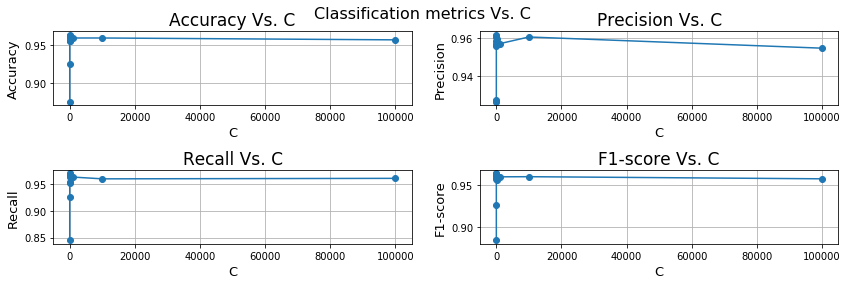

In [18]:
plot_metrics(df_linear)


### Tuning SVM with Gaussian kernel (C and sigma parameter)

In [24]:
warnings.filterwarnings('ignore')
Cs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
sigmas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
start = time.time()
best_c_gaussian, best_sigma, accuracy_gaussian, gaussian_df = tune_gaussian(X_train, y_train, X_dev, y_dev, Cs, sigmas)  
end = time.time()
print("Execution time:", end-start)


--- Tuning ---
C: 0.0001 sigma: 0.0001
C: 0.0001 sigma: 0.001
C: 0.0001 sigma: 0.01
C: 0.0001 sigma: 0.1
C: 0.0001 sigma: 1
C: 0.0001 sigma: 10
C: 0.0001 sigma: 100
C: 0.0001 sigma: 1000
C: 0.0001 sigma: 10000
C: 0.001 sigma: 0.0001
C: 0.001 sigma: 0.001
C: 0.001 sigma: 0.01
C: 0.001 sigma: 0.1
C: 0.001 sigma: 1
C: 0.001 sigma: 10
C: 0.001 sigma: 100
C: 0.001 sigma: 1000
C: 0.001 sigma: 10000
C: 0.01 sigma: 0.0001
C: 0.01 sigma: 0.001
C: 0.01 sigma: 0.01
C: 0.01 sigma: 0.1
C: 0.01 sigma: 1
C: 0.01 sigma: 10
C: 0.01 sigma: 100
C: 0.01 sigma: 1000
C: 0.01 sigma: 10000
C: 0.1 sigma: 0.0001
C: 0.1 sigma: 0.001
C: 0.1 sigma: 0.01
C: 0.1 sigma: 0.1
C: 0.1 sigma: 1
C: 0.1 sigma: 10
C: 0.1 sigma: 100
C: 0.1 sigma: 1000
C: 0.1 sigma: 10000
C: 1 sigma: 0.0001
C: 1 sigma: 0.001
C: 1 sigma: 0.01
C: 1 sigma: 0.1
C: 1 sigma: 1
C: 1 sigma: 10
C: 1 sigma: 100
C: 1 sigma: 1000
C: 1 sigma: 10000
C: 10 sigma: 0.0001
C: 10 sigma: 0.001
C: 10 sigma: 0.01
C: 10 sigma: 0.1
C: 10 sigma: 1
C: 10 sigma: 10
C: 1

,C,Sigma,Accuracy,Recall,Precision,F1_score
0,0.0001,0.0001,0.490600,0.000000,0.000000,0.000000
1,0.0001,0.0010,0.490600,0.000000,0.000000,0.000000
2,0.0001,0.0100,0.490600,0.000000,0.000000,0.000000
3,0.0001,0.1000,0.490600,0.000000,0.000000,0.000000
4,0.0001,1.0000,0.490600,0.000000,0.000000,0.000000
5,0.0001,10.0000,0.490600,0.000000,0.000000,0.000000
6,0.0001,100.0000,0.490600,0.000000,0.000000,0.000000
7,0.0001,1000.0000,0.490600,0.000000,0.000000,0.000000
8,0.0001,10000.0000,0.490600,0.000000,0.000000,0.000000
9,0.0010,0.0001,0.490600,0.000000,0.000000,0.000000


Best Accuracy ( 0.965433596119 ) is achieved for C = 100000  and sigma = 10000
Execution time: 10478.164714574814


### Execution with best parameters

#### Baseline Classifier

In [25]:
baseline(y_train, y_test)

Baseline Accuracy: 0.498181818182


0.49818181818181817

#### Linear SVM

In [26]:
alpha, beta, w = smo(y_train, X_train, best_c_linear)
us = eval_svm(alpha, beta, X_train, X_test, y_train, "linear")
accuracy_linear = accuracy(us, y_test)
print("Accuracy Linear SVM on test set:", accuracy_linear)

alpha_linear = pd.DataFrame(alpha, columns=["Alphas"])
alpha_linear.to_csv("alpha_linear.csv")

beta_linear = pd.DataFrame([beta], columns=["Beta"])
beta_linear.to_csv("beta_linear.csv")


Accuracy Linear SVM on test set: 0.960909090909


#### SVM with Gaussian kernel

In [27]:
alpha, beta, w = smo(y_train, X_train, best_c_gaussian, "gaussian", best_sigma)
us = eval_svm(alpha, beta, X_train, X_test, y_train, "gaussian", best_sigma)
accuracy_gaussian = accuracy(us, y_test)

print("Accuracy SVM with Gaussian kernel on test set:", accuracy_gaussian)

alpha_gaussian = pd.DataFrame(alpha, columns=["Alphas"])
alpha_gaussian.to_csv("alpha_gaussian.csv")

beta_gaussian = pd.DataFrame([beta], columns=["Beta"])
beta_gaussian.to_csv("beta_gaussian.csv")

Accuracy SVM with Gaussian kernel on test set: 0.967272727273
